In [1]:
import vectorbt as vbt
import numpy as np
import pandas as pd

In [2]:
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12, 5)

# data

Load OHLC data from cryptocurrency exchange Poloniex

In [3]:
ohlc_df = vbt.data.load_cryptopair('USDT_BTC', vbt.data.ago_dt(days=30), vbt.data.now_dt())
ohlc_df.head()

done. 1.55s


,O,H,L,C,V
date,,,,,
2017-10-25 03:00:00,5370.330796,5430.000000,5367.630796,5430.000000,193615.451337
2017-10-25 03:05:00,5430.000000,5470.000000,5430.000000,5457.000000,214741.121863
2017-10-25 03:10:00,5457.000000,5470.000000,5432.000000,5470.000000,101005.257120
2017-10-25 03:15:00,5454.286393,5499.000000,5454.286393,5491.564284,291424.871574
2017-10-25 03:20:00,5491.564284,5497.168356,5465.279693,5475.709172,66058.592478


In [4]:
# No future data
rate_sr = ohlc_df.O

    count         mean         std      min      25%          50%     75%  \
O  8640.0  6946.226363  808.470537  5302.64  6218.75  7076.353793  7546.2   

           max  
O  8383.465575  


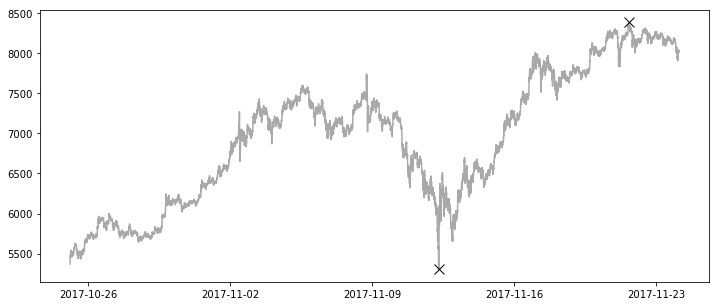

In [5]:
vbt.graphics.plot_line(rate_sr)

# indicators

Calculate EMA indicators

In [6]:
fast_ma_sr = vbt.indicators.EMA(rate_sr, 100)
slow_ma_sr = vbt.indicators.EMA(rate_sr, 300)

# signals

Generate signals based on conditions

    1. Go long whenever fast EMA is over slow EMA, while go short when opposite occurs

In [7]:
ma_evector = vbt.signals.DMAC_evector(fast_ma_sr, slow_ma_sr)
ma_xvector = vbt.signals.DMAC_xvector(fast_ma_sr, slow_ma_sr)

Both, entry and exit vectors, are sequences of 0 and 1 (bit-vectors) to allow fast vector operations.

We reduce both vectors to contain only signals that are first in their sequences, since we are looking for crossover.

In [8]:
ma_evector = vbt.vector.first(ma_evector)
ma_xvector = vbt.vector.first(ma_xvector)

    2. Go short whenever price drops by 10%

In [9]:
trailstop_xvector = vbt.signals.trailstop_xvector(rate_sr, ma_evector, 0.1 * rate_sr)

Combine MA exit strategy with trailing stop and pick every first exit out of sequence.

In [10]:
ma_xvector = vbt.vector.OR(ma_xvector, trailstop_xvector)
ma_xvector = vbt.vector.first(ma_xvector)

To apply an additional filter, generate your own bit-vector and use `vector.AND/OR/XOR` operations

# positions

Generete positions out of both vectors (merge and reduce)

In [11]:
pos_sr = vbt.positions.from_vectors(rate_sr, ma_evector, ma_xvector)
pos_sr.head()

date
2017-10-25 03:05:00    1
2017-10-27 13:20:00   -1
2017-10-29 07:00:00    1
2017-11-04 00:55:00   -1
2017-11-04 13:55:00    1
dtype: int64

Position series has always even number of positions. First position is always long, the last one always short. This kind of fixed structure (`[0::2]` for long, `[1::2]` for short) makes further manipulations, such as calculation of equity, very easy.

Visualize entries and exits

   count        mean         std       min        25%        50%         75%  \
O   22.0  122.174677  460.306548 -957.1754 -62.446776  81.534339  159.263856   

           max  
O  1363.143512  


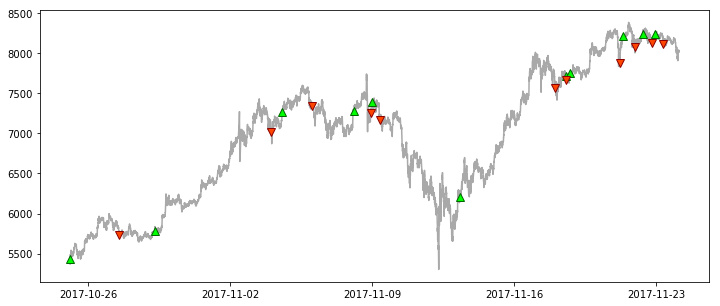

In [12]:
vbt.positions.plot(rate_sr, pos_sr)

# returns

Generate % returns out of positions. Takes into account fees.

In [13]:
posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, 0.0025)
posret_sr.head()

date
2017-10-25 03:05:00   -0.002500
2017-10-27 13:20:00    0.052610
2017-10-29 07:00:00   -0.002500
2017-11-04 00:55:00    0.210157
2017-11-04 13:55:00   -0.002500
dtype: float64

Position returns series (`posret`) inherits the structure of the position series and make them redundant. Because we apply fees, we get negative returns on long. If fees are zero, returns on long are also zero, but still included in the series. 

Generate hold returns.

In [14]:
vbt.returns.on_hold(rate_sr, 0.0015)

date
2017-10-25 03:00:00   -0.00150
2017-11-24 02:55:00    0.49301
dtype: float64

   count      mean       std       min       25%     50%     75%       max
0   22.0  0.016958  0.065445 -0.032891 -0.004826 -0.0025 -0.0025  0.216712


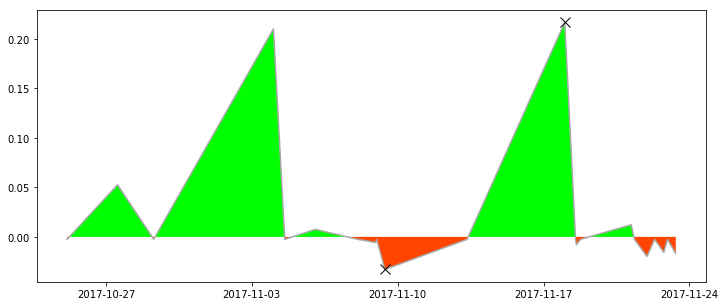

In [15]:
vbt.returns.plot(posret_sr)

# equity

Generate equity in base and quote currency from position returns

In [16]:
base_sr = vbt.equity.base(rate_sr, posret_sr)
base_sr.head()

date
2017-10-25 03:00:00            NaN
2017-10-25 03:05:00    5416.425000
2017-10-25 03:10:00    5443.357500
2017-10-25 03:15:00    5440.650677
2017-10-25 03:20:00    5477.835373
dtype: float64

In [17]:
quote_sr = vbt.equity.quote(rate_sr, posret_sr)
quote_sr.head()

date
2017-10-25 03:00:00       NaN
2017-10-25 03:05:00    0.9975
2017-10-25 03:10:00    0.9975
2017-10-25 03:15:00    0.9975
2017-10-25 03:20:00    0.9975
dtype: float64

Base and quote are NaN before the first entry or if no positions were taken

Visualize both equities

base
    count       mean        std         min         25%        50%  \
0  8639.0 -17.726325  331.08703 -656.651027 -215.287827 -93.410682   

          75%          max  
0  182.809035  1316.238113  


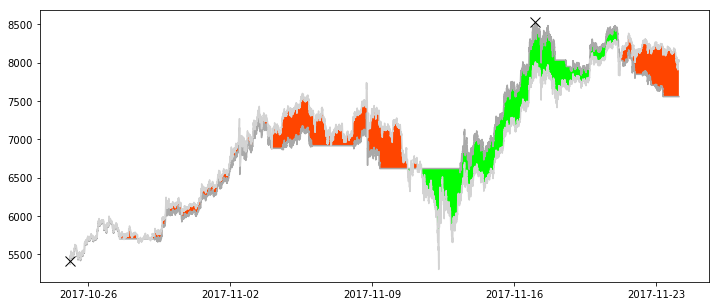

In [18]:
vbt.equity.plot_base(rate_sr, base_sr)

quote
    count      mean       std       min       25%       50%       75%  \
0  8639.0 -0.001401  0.046846 -0.090255 -0.029758 -0.016067  0.022159   

        max  
0  0.248223  


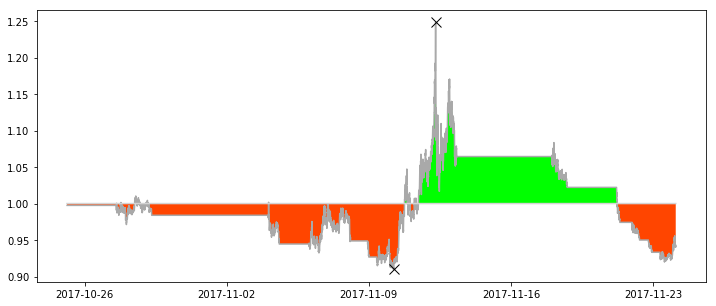

In [19]:
vbt.equity.plot_quote(rate_sr, quote_sr)

Equity diffs (`eqd`) are absolute returns if initial investment was 1. They are used in calculation of performance and risk/profit indicators such as sharpe ratio.

In [20]:
eqd_sr = vbt.equity.base_diffs(rate_sr, posret_sr)
eqd_sr.head()

date
2017-10-27 13:20:00     284.960812
2017-11-04 00:55:00    1195.191507
2017-11-06 01:05:00      51.956716
2017-11-08 22:30:00     -38.645690
2017-11-09 09:15:00    -225.105430
dtype: float64

# performance

Print summary of multiple KPIs applied on equity diffs

In [21]:
vbt.performance.print_summary(eqd_sr)

{
  "performance": {
    "profit": 2322.123986355782,
    "averages": {
      "trade": 211.10218057779838,
      "gain": 611.9681672833387,
      "loss": 122.95280834348523
    },
    "winrate": 0.45454545454545453,
    "payoff": 4.9772605890686386,
    "PF": 4.1477171575571985,
    "RF": 5.6541664669087055
  },
  "risk/return profile": {
    "sharpe": 0.3736518031098608,
    "sortino": 3.151902580398572,
    "maxdd": 410.6925397308569
  }
}


# optimizer.gridsearch

The classic optimization method is grid search (or exhaustive search). It exhaustively generates candidates from a grid of parameter values and applies them on the series. 

This method brings some advantages:
- its simple to implement
- 2d-combinations can be visualized using heatmaps
- can be used to discover hidden patterns in combinations
- highly parallelizable

But also drawbacks are possible:
- not flexible enough to fit changing financial markets
- prone to overfitting
- no intermediate feedback

**Grid search consists of 4 levels:**

| Level | Motivation | Module | Map structure |
|-|-|-|-|
| 1 | Calculate equity diffs | `seriesmap` | `[(,)]` |
| 2 | Calculate KPIs on equity diffs and compare | `nummap` | `pd.Series` |
| 3 | Combine multiple KPIs into a single score and compare | `scoremap` | `pd.Series` |
| 4 | Find patterns by building a heatmap | `matrix` | `pd.DataFrame` |

At the end we will be able to compare performance of different trading strategies

## L1
## seriesmap

In [22]:
import vectorbt.optimizer.gridsearch as grids

Calculate equity diffs for a range of EMA combinations

    1. Precalculate all EMAs

In [23]:
# Init
ma_func = lambda window: vbt.indicators.EMA(rate_sr, window)
min_ma, max_ma, step = 1, 1000, 10
fees = 0.0025

# Cache moving averages
param_range = grids.params.range_params(min_ma, max_ma, step)
mamap = dict(grids.seriesmap.from_func(ma_func, param_range))

cores: 4
processes: 3
starmap: False
calcs: 101 (~0.07s) ..
done. 0.27s


    2. For each EMA combination, generate respective equity diffs

In [24]:
# Func
def ma_eqdfunc(fast_ma, slow_ma):
    # Requires multiple layers of calculations
    fast_ma_sr = mamap[fast_ma]
    slow_ma_sr = mamap[slow_ma]
    entries = vbt.vector.first(vbt.signals.DMAC_evector(fast_ma_sr, slow_ma_sr))
    exits = vbt.vector.first(vbt.signals.DMAC_xvector(fast_ma_sr, slow_ma_sr))
    pos_sr = vbt.positions.from_vectors(rate_sr, entries, exits)
    if len(pos_sr.index) == 0:
        return pd.Series([])
    posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = vbt.equity.base_diffs(rate_sr, posret_sr)
    return eqd_sr

# Params
param_space = grids.params.combine_rep_params(min_ma, max_ma, step, 2)

In [25]:
ma_eqdmap = grids.seriesmap.from_func(ma_eqdfunc, param_space)

cores: 4
processes: 3
starmap: True
calcs: 5151 (~10.92s) ..
done. 11.32s


Generate equity diffs for random positions. Number of positions is the same as for EMA, to be comparable.

In [26]:
# Func
def random_eqdfunc(n):
    entries = vbt.signals.random_vector(rate_sr, n)
    exits = vbt.signals.random_vector(rate_sr, n, excl_vector=entries)
    pos_sr = vbt.positions.from_vectors(rate_sr, entries, exits)
    if len(pos_sr.index) == 0:
        return pd.Series([])
    posret_sr = vbt.returns.from_positions(rate_sr, pos_sr, fees)
    eqd_sr = vbt.equity.base_diffs(rate_sr, posret_sr)
    return eqd_sr

# Params
param_range = np.array(grids.mapper.map(lambda sr: len(sr.index), list(zip(*ma_eqdmap))[1]))+1

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.19s) ..
done. 2.68s


In [27]:
random_eqdmap = grids.seriesmap.from_func(random_eqdfunc, param_range)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~17.27s) ..
done. 11.60s


## L2
## nummap

Apply KPI on each equity diffs series

In [28]:
ma_exp_nummap = grids.nummap.from_seriesmap(ma_eqdmap, vbt.performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.61s) ..
done. 2.82s
min (11, 141): -10.1708140806
max (721, 1001): 1516.45506251


In [29]:
ma_sharpe_nummap = grids.nummap.from_seriesmap(ma_eqdmap, vbt.performance.sharpe)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.58s) ..
done. 2.86s
min (1, 11): -0.30755002454
max (921, 971): 11.5436459331


In [30]:
random_exp_nummap = grids.nummap.from_seriesmap(random_eqdmap, vbt.performance.expectancy)

cores: 4
processes: 3
starmap: False
calcs: 5151 (~0.37s) ..
done. 2.73s
min 3: -1569.06605954
max 1: 2667.13650223


Compare quantile distributions of EMA and random strategy KPIs

            count        mean         std          min         25%  \
nummap     5050.0  664.486800  336.128599   -10.170814  457.539295   
benchmark  5151.0  295.238195  385.074166 -1569.066060   44.697030   

                  50%         75%          max  
nummap     726.714601  912.924321  1516.455063  
benchmark  228.755282  485.784727  2667.136502  


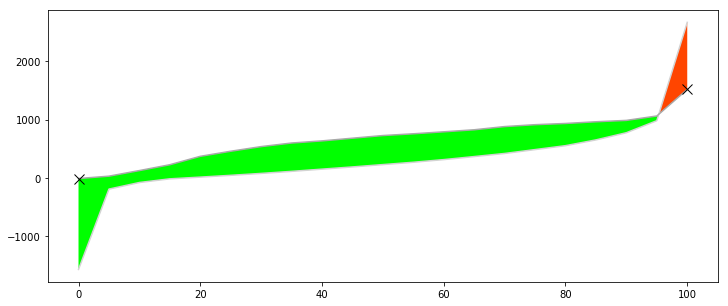

In [31]:
grids.nummap.compare_quantiles(ma_exp_nummap, random_exp_nummap)

Compare KPI distribution to that of random map

            count        mean         std          min         25%  \
nummap     5050.0  664.486800  336.128599   -10.170814  457.539295   
benchmark  5151.0  295.238195  385.074166 -1569.066060   44.697030   

                  50%         75%          max  
nummap     726.714601  912.924321  1516.455063  
benchmark  228.755282  485.784727  2667.136502  


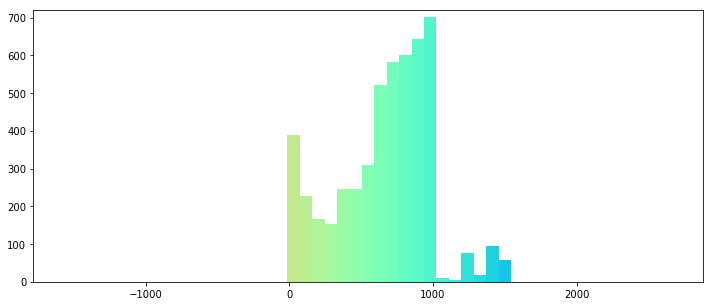

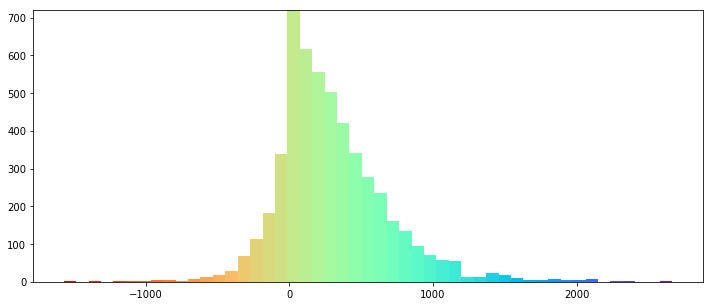

In [33]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
grids.nummap.compare_hists(ma_exp_nummap, random_exp_nummap, 50, cmap, norm)

## L3
## scoremap

Take into account multiple weighted KPIs and generate a score from 1 to 100

In [34]:
ma_scoremap = grids.scoremap.from_nummaps([ma_exp_nummap, ma_sharpe_nummap], [2/3, 1/3], [False, False])

done. 0.01s
min (1, 1): 1.0
max (931, 961): 88.4871579772


## L4
## matrix

Reshape 2d-parameter grid into a matrix and display as a heatmap

In [35]:
ma_matrix = grids.matrix.from_nummap(ma_exp_nummap, symmetric=True).fillna(0)

done. 1.56s


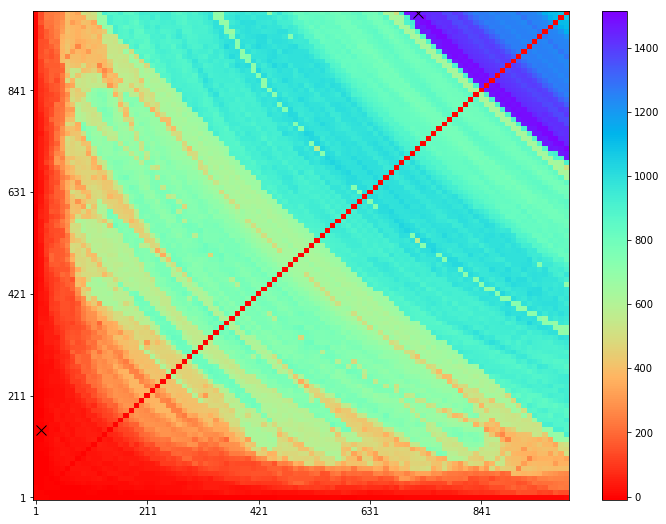

In [36]:
cmap = plt.cm.rainbow_r
norm = plt.Normalize()
matplotlib.rcParams['figure.figsize'] = (12, 9)
grids.matrix.plot(ma_matrix, cmap, norm)
matplotlib.rcParams['figure.figsize'] = (12, 5)